In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy

In [2]:
img = imread('/oasis/projects/nsf/csd395/yuncong/CSHL_data_processed/MD589_lossless_aligned_cropped_grayscale/MD589_0134_lossless_aligned_cropped_grayscale.tif')
im = img[7245:7245+208, 2845:2845+190]

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/external/tifffile/tifffile_local.py:3246: UserWarning: unexpected end of lzw stream (code 0)
  warnings.warn("unexpected end of lzw stream (code %i)" % code)


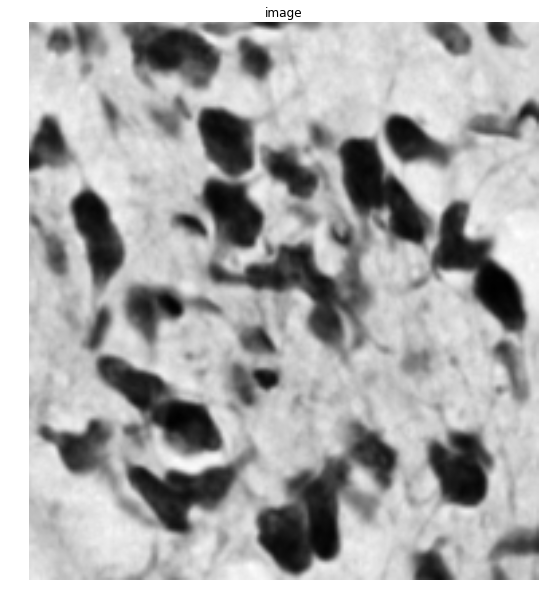

In [8]:
plt.figure(figsize=(10,10));
plt.imshow(im, cmap=plt.cm.gray);
plt.axis('off');
plt.title('image');
plt.savefig('/home/yuncong/Brain/image.png');

In [18]:
seed_im.shape

(208, 190, 3)

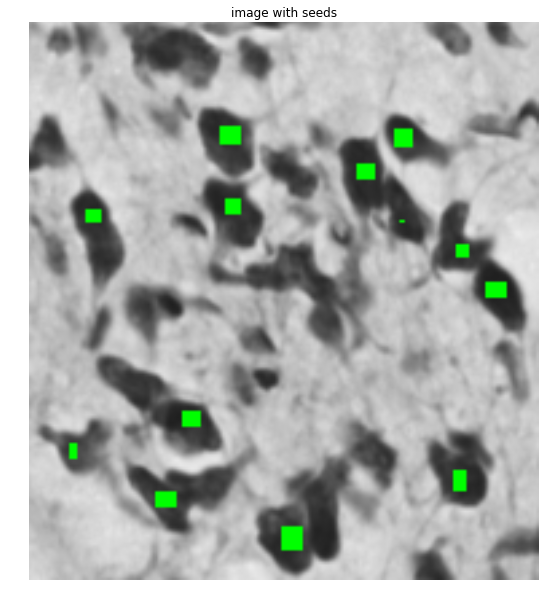

In [141]:
seed_boxes = [
( 39 , 46 , 71 , 79 ),
( 66 , 72 , 73 , 79 ),
( 70 , 75 , 21 , 27 ),
( 145 , 151 , 57 , 64 ),
( 157 , 163 , 15 , 18 ),
( 175 , 181 , 47 , 55 ),
( 188 , 197 , 94 , 102 ),
( 167 , 175 , 158 , 163 ),
( 97 , 103 , 170 , 178 ),
( 83 , 88 , 159 , 164 ),
( 74 , 75 , 138 , 140 ),
( 53 , 59 , 122 , 129 ),
( 40 , 47 , 136 , 143 )]

seed_im = gray2rgb(im)

for y1,y2,x1,x2 in seed_boxes:
    seed_im[y1:y2, x1:x2] = (0,255,0)
    
plt.figure(figsize=(10,10));
plt.imshow(seed_im);
plt.axis('off');
plt.title('image with seeds');

In [37]:
n = len(seed_boxes)

In [163]:
phi = -1 * np.ones((n,)+im.shape)

for i, (y1,y2,x1,x2) in enumerate(seed_boxes):
    phi[i, y1-1:y2+1, x1-1:x2+1] = 0
    phi[i, y1:y2, x1:x2] = 1
    phi[i] = reinitialize(phi[i], n_iter=2000)

terminate in 1999 iterations
terminate in 1842 iterations
terminate in 1999 iterations
terminate in 1975 iterations
terminate in 1999 iterations
terminate in 1999 iterations
terminate in 1999 iterations
terminate in 1999 iterations
terminate in 1999 iterations
terminate in 1999 iterations
terminate in 1965 iterations
terminate in 1985 iterations
terminate in 1999 iterations


In [159]:
from skimage.segmentation import mark_boundaries

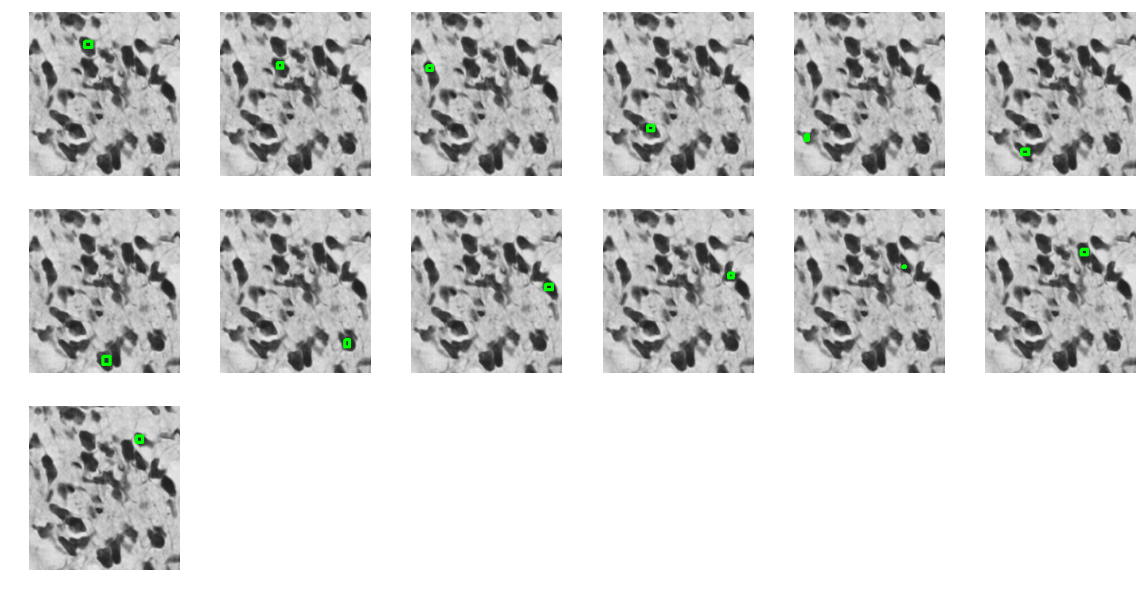

In [164]:
rgb_im = gray2rgb(im)

fig, axes = plt.subplots(1+n/6, 6, figsize=(20, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i >= n:
        ax.set_visible(False)
    else:
#         y1,y2,x1,x2 = seed_boxes[i]
#         sim = mark_boundaries(seed_im, phi[i].astype(np.int))
        marked_im = draw_zero_crossing(phi[i], rgb_im)
        ax.imshow(marked_im);
        ax.axis('off');

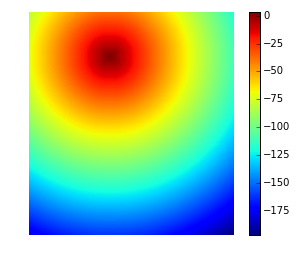

In [165]:
plt.imshow(phi[0]);
plt.colorbar();
plt.axis('off');

terminate in 4 iterations


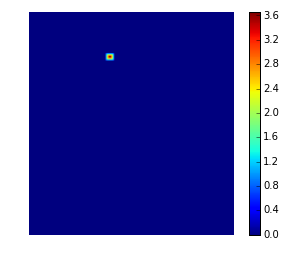

In [162]:
plt.imshow(reinitialize(phi[0], n_iter=2000));
plt.colorbar();
plt.axis('off');

In [103]:
from skimage.morphology import disk

In [115]:
def draw_zero_crossing(u, bg=None, linewidth=1):
    h, w = u.shape
    s = np.sign(u)
    zero_crossings = np.where(np.c_[np.diff(s, axis=1), np.zeros(h,)] + 
                              np.r_[np.diff(s, axis=0), np.zeros((1,w))])
    
    overlay = np.zeros((h,w), np.bool)
    if bg.dtype == np.float:
        overlay[zero_crossings] = 1
    else:
        overlay[zero_crossings] = 255
        
    overlay = binary_dilation(overlay, disk(linewidth))
    
    if bg is None:
        return overlay
    else:
        res = bg.copy()
        if bg.dtype == np.float:
            res[overlay] = [0,1,0]
        else:
            res[overlay] = [0,255,0]
        return res

In [ ]:
def step(us, g, cc = 1., eps1 = 1e-10):
    
    phis = -us
    
    new_phis = np.zeros_like(phis)
    n, h, w = phi.shape
    for i in range(n):
        u = phis[i]
    
        dudy, dudx = np.gradient(u)
        du_norm = np.sqrt(dudy**2 + dudx**2)
        du_unit_y = dudy / (du_norm + eps1)
        du_unit_x = dudx / (du_norm + eps1)
        dudydy, _ = np.gradient(du_unit_y)
        _, dudxdx = np.gradient(du_unit_x)
        k = dudydy + dudxdx # divergence of normalized gradient
        
        competition_term = lamnda_cell*(1-ci)**2 - lambda_bg*(1-cb)**2*(np.sum(phis>0)-(u>0).astype(np.int))
        smoothness_term = nu*g*k + mu*(dgdy*du_unit_y + dgdx*du_unit_x)
        repulsion_term = omega*(np.sum(phis<0, axis=0)-(u<0).astype(np.int))
        
        dudt = competition_term + smoothness_term + repulsion_term
        u += dudt

        assert not np.isnan(u).any() and not np.isinf(u).any()
    
        new_phis[i] = u
    
    return -new_phis

In [157]:
def reinitialize(u, n_iter=10):
    
    h, w = u.shape

    s = u/np.sqrt(u**2+1)

    u2 = u.copy()
    
    for j in range(n_iter):
        dx = np.diff(u2, axis=1)
        dy = np.diff(u2, axis=0)
    #     b = np.c_[dx, -u2[:,-1]]
        b = np.c_[dx, np.zeros((h,1))]
        a = np.c_[np.zeros((h,1)), dx]
    #     d = np.r_[dy, -u2[-1,:][None,:]]
        d = np.r_[dy, np.zeros((1,w))]
        c = np.r_[np.zeros((1,w)), dy]

        if j > 1:
            du_norm_prev = du_norm
        
        du_norm = np.zeros_like(u)
        du_norm[u>0] = np.sqrt(np.maximum(np.maximum(0,a[u>0])**2, np.minimum(0,b[u>0])**2)+
                               np.maximum(np.maximum(0,c[u>0])**2, np.minimum(0,d[u>0])**2))

        du_norm[u<0] = np.sqrt(np.maximum(np.maximum(0,b[u<0])**2, np.minimum(0,a[u<0])**2)+
                           np.maximum(np.maximum(0,d[u<0])**2, np.minimum(0,c[u<0])**2))

#     dudy, dudx = np.gradient(u2)
#     du_norm = np.sqrt(np.maximum(np.maximum(dudy,0)**2, np.minimum(dudy,0)**2) + 
#                       np.maximum(np.maximum(dudx,0)**2, np.minimum(dudx,0)**2))

        u2 += 0.2*s*(1-du_norm)
    
        if j > 1:
            if np.abs(np.sum(du_norm_prev - du_norm)) < 1e-20:
                break
    
    print 'terminate in', j, 'iterations'
    
    assert not np.isnan(u2).any() and not np.isinf(u2).any()
    
#     plt.matshow(u);
#     plt.show()

#     plt.matshow(u2);
#     plt.show()

#     plt.matshow(du_norm-1., vmin=0, vmax=1);
#     plt.colorbar();
#     plt.show()
    
    return u2